In [189]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from skimage.color import rgb2gray
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Dropout, TimeDistributed, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, Callback

In [190]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [191]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    fo.close()
    return dict

In [192]:
def get_image(image_data):
    split_color = 1024
    colors = {}
    # get red (0), green (1), blue (2) and create three 1024 arrays
    for i in range(0, 3):
        colors[i] = image_data[i*split_color:(i+1)*split_color]

    # convert each of the rgb vectors into a 1024x3 array 
    rgb_list = []
    for i in range(0, split_color):
        rgb_temp = []
        for k in range(0, 3):
            rgb_temp.append(colors[k][i])
        rgb_list.append(rgb_temp)

    # convert the rgb pixels into a 32x32x3 array
    image_list = []
    for i in range(0, 32):
        image_list.append(rgb_list[i*32: (i+1)*32])
    return image_list

In [193]:
def predictImage(image, centers_dict, kmeans):
    return_image_rgb = []
    return_image_hot = []
    for i in range(0,32):
        color_pred = list(kmeans.predict(image[i]))
        
        return_rgb = [centers_dict[x] for x in color_pred]
        return_hot = [one_hot_dict[x] for x in color_pred]
        
        return_image_rgb.append(return_rgb)
        return_image_hot.append(return_hot)
    return np.array(return_image_rgb), np.array(return_image_hot)

# Extract Train and Test Batches

In [194]:
train_data_dict = {}
train_label_dict = {}
path = 'gdrive/MyDrive/colorizer_images/'
for i in range(1, 6):
    file_name = 'data_batch_' + str(i)
    batch = unpickle(path + file_name)
    train_data_dict[file_name] = batch[b'data']
    train_label_dict[file_name] = batch[b'labels']

In [195]:
batch = unpickle(path + 'test_batch')
test_data = batch[b'data']
test_label = batch[b'labels']

We want to limit our training experimentation to just batch 1 to begin.

In [196]:
batch1_raw = train_data_dict['data_batch_1']

# Convert to RGB (32x32x3)

In [197]:
# convert our image into a 32x32x3 RGB image
train_images = []
for image in tqdm(batch1_raw[:2500]):
    train_images.append(np.array(get_image(image)))

test_images = []
for image in tqdm(test_data[:2000]):
    test_images.append(np.array(get_image(image)))

100%|██████████| 2000/2000 [00:03<00:00, 560.66it/s]


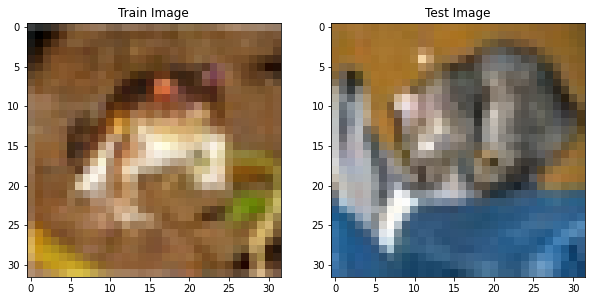

In [198]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(train_images[0], interpolation='nearest', cmap='gray')
ax[0].title.set_text('Train Image')

ax[1].imshow(test_images[0], interpolation='nearest', cmap='gray')
ax[1].title.set_text('Test Image')

# Obtain Centroid RGB Pixels (using KMeans)

### Process Sample

In [199]:
pixels_all = []

for l in tqdm(range(0, len(train_images))):
    for i in range(0,32):
        for k in range(0,32):
            pixels_all.append(tuple(train_images[l][i][k]))

100%|██████████| 2500/2500 [00:04<00:00, 519.05it/s]


In [200]:
pixels_all = set(pixels_all)
pixels_all = [list(x) for x in pixels_all]

In [201]:
# sample pixels
len_pixels = len(pixels_all)
len_pixels_sample = int(len_pixels*.3)

sel_indices = random.sample(range(0, len_pixels), len_pixels_sample)
pixels_sample = [pixels_all[x] for x in sel_indices]

### Run KMeans

In [212]:
num_k = 4

In [203]:
kmeans = KMeans(n_clusters=num_k)
kmeans.fit(pixels_sample)

KMeans(n_clusters=4)

In [215]:
# map the centroid pixels
centers_dict = {}
for i in range(0,num_k):
  centers_dict[i] = [int(np.round(x)) for x in kmeans.cluster_centers_[i]]

In [216]:
# initialize mapping to one hot
knn_outputs = range(len(centers_dict))
lb = LabelBinarizer()
one_hot = lb.fit_transform(knn_outputs)
one_hot_dict = {}
for k in knn_outputs:
    one_hot_dict[k] = list(one_hot[k])

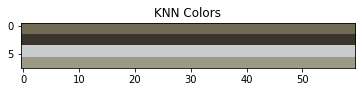

In [220]:
output_knn = []
for k in centers_dict:
  output_knn.append([centers_dict[k]]*60)
  output_knn.append([centers_dict[k]]*60)
  
plt.title('KNN Colors')
plt.imshow(np.array(output_knn))

# Convert RGBs to Nearest Centroid RGB

In [221]:
train_images_knn_rgb = []
train_images_knn_hot = []
for image in tqdm(train_images):
    return_image_rgb, return_image_hot = predictImage(image, centers_dict, kmeans)
    train_images_knn_rgb.append(return_image_rgb)
    train_images_knn_hot.append(return_image_hot)

100%|██████████| 2500/2500 [01:14<00:00, 33.62it/s]


In [222]:
test_images_knn_rgb = []
test_images_knn_hot = []
for image in tqdm(test_images):
    return_image_rgb, return_image_hot = predictImage(image, centers_dict, kmeans)
    test_images_knn_rgb.append(return_image_rgb)
    test_images_knn_hot.append(return_image_hot)

100%|██████████| 2000/2000 [00:55<00:00, 35.89it/s]


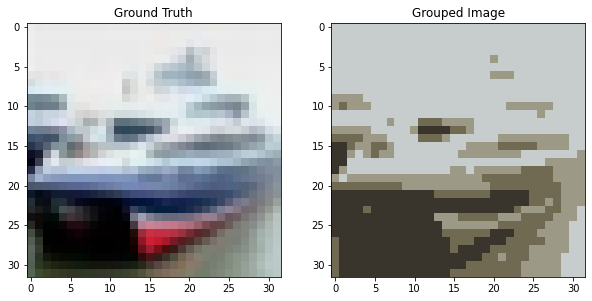

In [223]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(test_images[1], interpolation='nearest', cmap='gray')
ax[0].title.set_text('Ground Truth')

ax[1].imshow(test_images_knn_rgb[1], interpolation='nearest', cmap='gray')
ax[1].title.set_text('Grouped Image')

# Get X Features (GrayScaled)

In [224]:
train_images_grayscale = []
for image in train_images:
    train_images_grayscale.append(rgb2gray(image))

In [225]:
test_images_grayscale = []
for image in test_images:
    test_images_grayscale.append(rgb2gray(image))

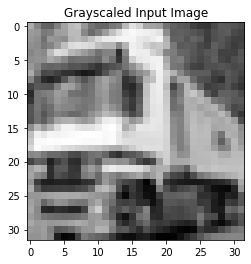

In [226]:
plt.title('Grayscaled Input Image')
plt.imshow(train_images_grayscale[1], interpolation='nearest', cmap='gray')

# Model Training

In [227]:
# grayscale inputs
x_train_gray = np.array(train_images_grayscale).reshape(-1,32,32,1)
x_test_gray = np.array(test_images_grayscale).reshape(-1,32,32,1)

In [230]:
# KNN colors flat
y_train_knn = np.array(train_images_knn_hot).reshape(-1,32*32*num_k)
y_test_knn = np.array(test_images_knn_hot).reshape(-1,32*32*num_k)

In [319]:
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='linear', input_shape=(32,32,1), padding='same'))
model.add(Conv2D(64, (5, 5), activation='linear', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), activation='linear', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, (5, 5), activation='linear', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='sigmoid'))

# model.add(Activation('softmax'))

In [320]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 conv2d_61 (Conv2D)          (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 16, 16, 64)        102464    
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

In [327]:
num_epochs = 20

In [328]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [329]:
model_results = model.fit(x_train_gray, y_train_knn, validation_split=0.2, 
                          epochs=num_epochs, batch_size=32)

Epoch 1/20
63/63 [==============================] - 2s 14ms/step - loss: 0.1246 - val_loss: 0.5143
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 0.1017 - val_loss: 0.5445
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0958 - val_loss: 0.5195
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0930 - val_loss: 0.5549
Epoch 5/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0927 - val_loss: 0.5021
Epoch 6/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0889 - val_loss: 0.5287
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0874 - val_loss: 0.5648
Epoch 8/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0852 - val_loss: 0.5682
Epoch 9/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0828 - val_loss: 0.5652
Epoch 10/20
63/63 [==============================] - 1s 11ms/step - loss: 0.0816 - val_loss: 0.5166
Epoch 11/

# Visualize Outputs

In [330]:
first_10_test = model.predict(x_test_gray[0:8]).reshape(-1,32,32,num_k)

In [331]:
def encodeToRGB(output):
    out_print = []
    for i in range(0,32):
        temp = []
        for k in range(0, 32):
            temp.append(centers_dict[np.argmax(output[i][k])])
        out_print.append(temp)
    out_print = np.array(out_print)
    return out_print

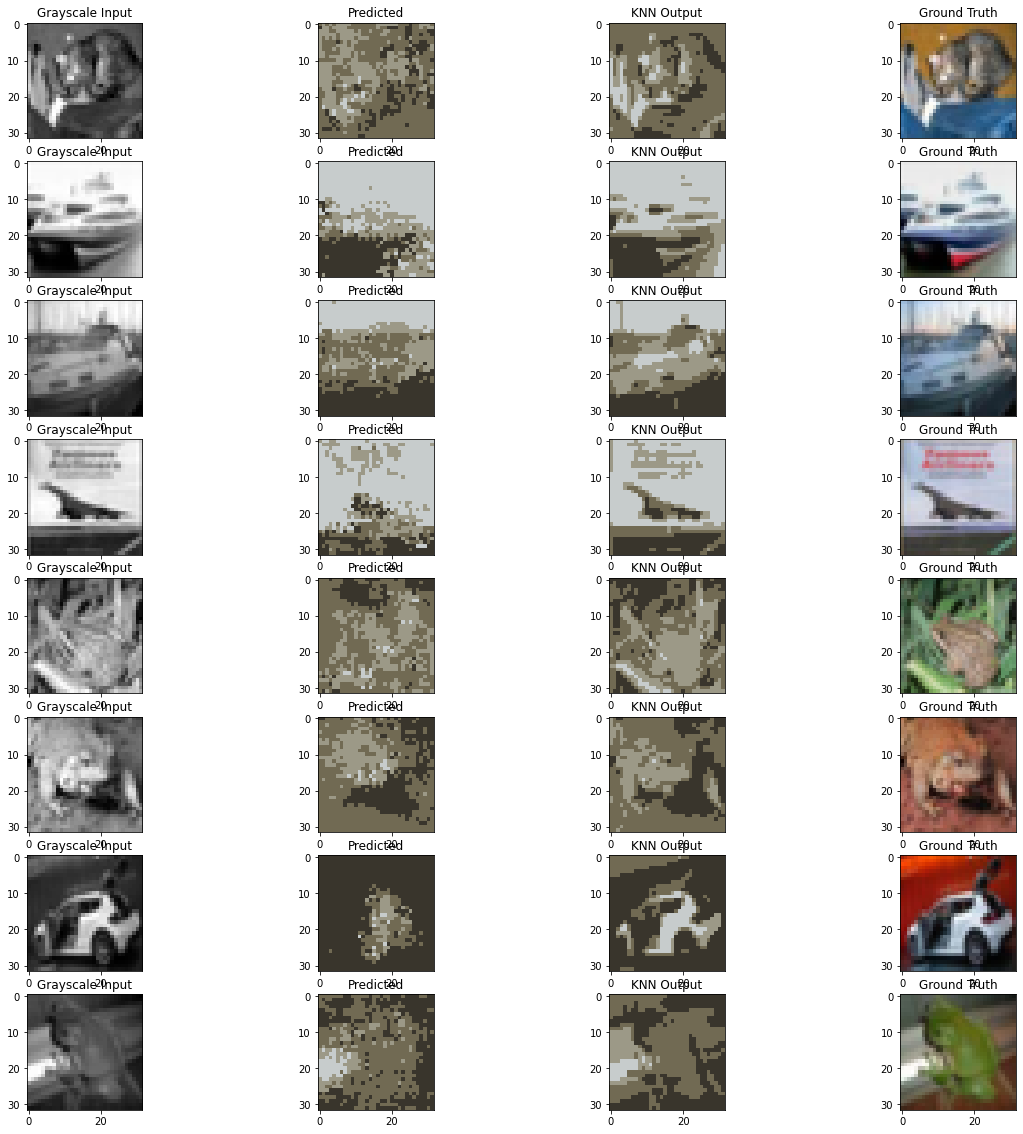

In [332]:
first_10_color = []
f, axarr = plt.subplots(8,4, figsize=(20,20))
for index, image in enumerate(first_10_test):
    first_10_color.append(encodeToRGB(image))
    axarr[index, 0].imshow(test_images_grayscale[index], interpolation='nearest', cmap='gray')
    axarr[index, 0].title.set_text('Grayscale Input')
    
    axarr[index, 1].imshow(first_10_color[index], interpolation='nearest')
    axarr[index, 1].title.set_text('Predicted')
    
    axarr[index, 2].imshow(test_images_knn_rgb[index], interpolation='nearest')
    axarr[index, 2].title.set_text('KNN Output')
    
    axarr[index, 3].imshow(test_images[index], interpolation='nearest')
    axarr[index, 3].title.set_text('Ground Truth')